<a href="https://colab.research.google.com/github/berteyoussouf/tp1/blob/main/TP3_optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP3 Optimisaation
# M1-DS
# Prof :  Arthur Marmin
# BERTE Youssouf

### **Introduction**  

Ce projet vise à implémenter l'algorithme du simplexe pour résoudre un problème d'optimisation en robotique. Nous cherchons à maximiser la distance de sécurité d'un robot contraint à se déplacer sur une ligne droite dans un environnement polygonal.  

L'étude combine :  
1. Une **implémentation rigoureuse** du simplexe (phases I/II)  
2. Son application pour **optimiser la position du robot**  
3. Une **validation** par comparaison avec SciPy  

Les résultats permettront d'identifier la position optimale et les contraintes limitant la sécurité du robot.  


# Partie 1:

Question 1: Implémentation de la méthode du simplexe


In [4]:
import numpy as np

def simplex_method(A, b, c, is_init=False):
    """
    Implémentation de la méthode du simplexe

    Args:
        A: matrice des contraintes (m x n)
        b: vecteur des termes constants (m)
        c: vecteur des coûts (n)
        is_init: booléen indiquant si on est en phase I (initialisation) ou phase II

    Returns:
        solution optimale ou indication de problème non borné ou infaisable
    """
    m, n = A.shape
    w = np.zeros(n)

    # Phase I: Trouver un sommet initial
    if not is_init:
        # Créer le problème auxiliaire pour la phase I
        A_aux = np.hstack([A, np.eye(m)])
        c_aux = np.concatenate([np.zeros(n), np.ones(m)])
        b_aux = b.copy()

        # Solution initiale pour la phase I
        I_init = list(range(n, n+m))  # Variables artificielles
        J_init = list(range(n))

        # Appel récursif pour la phase I
        result = simplex_method(A_aux, b_aux, c_aux, is_init=True)

        if result is None or np.any(result[n:] > 1e-6):
            return None  # Problème infaisable

        # Récupérer la solution de la phase I
        w = result[:n]
        I = [i for i in range(n) if abs(w[i]) > 1e-6]
        if len(I) < m:
            # Besoin de compléter la base
            for j in range(n):
                if j not in I:
                    Aj = A[:, j]
                    if np.linalg.matrix_rank(A[:, I + [j]]) > np.linalg.matrix_rank(A[:, I]):
                        I.append(j)
                        if len(I) == m:
                            break
    else:
        # Initialisation pour la phase I
        I = list(range(n - m, n))  # On suppose que les dernières variables forment une base initiale
        w = np.zeros(n)
        w[I] = np.linalg.solve(A[:, I], b)

    J = [j for j in range(n) if j not in I]

    while True:
        # Étape 1: Calcul des coûts réduits
        A_I = A[:, I]
        A_I_inv = np.linalg.inv(A_I)
        c_I = c[I]
        r = c[J] - A[:, J].T.dot(A_I_inv.T.dot(c_I))

        # Étape 2: Critère d'arrêt
        if np.all(r >= -1e-6):
            break

        # Étape 3: Choix de la variable entrante
        j_idx = np.argmin(r)
        j = J[j_idx]

        # Étape 4: Calcul de la direction
        Delta_j = A_I_inv.dot(A[:, j])

        # Étape 5: Test d'optimalité
        if np.all(Delta_j <= 1e-6):
            return None  # Problème non borné

        # Étape 6: Choix de la variable sortante
        I_plus = [i for i in range(m) if Delta_j[i] > 1e-6]
        if not I_plus:
            return None  # Problème non borné

        ratios = [w[I[i]] / Delta_j[i] for i in I_plus]
        k_idx = np.argmin(ratios)
        k = I[I_plus[k_idx]]
        x_j = ratios[k_idx]

        # Étape 7: Mise à jour
        w_I_new = w[I] - x_j * Delta_j
        w_new = np.zeros(n)
        w_new[I] = w_I_new
        w_new[j] = x_j

        # Mise à jour des ensembles
        I.remove(k)
        I.append(j)
        I.sort()
        J = [j for j in range(n) if j not in I]
        w = w_new

    solution = np.zeros(n)
    solution[I] = np.linalg.solve(A[:, I], b)
    return solution

Question 2: Test sur l'exemple du cours

In [ ]:
# Définition du problème
A = np.array([
    [1, 2, -1, 0],
    [2, 3, 0, -1]
])
b = np.array([12, 20])
c = np.array([1, 3, 0, 0])

# Résolution
solution = simplex_method(A, b, c)
print("Solution optimale:", solution)

Solution optimale: [12.  0.  0.  4.]


Question 3

In [5]:
import numpy as np

def simplex_method_with_detailed_print(A, b, c):
    m, n = A.shape
    tol = 1e-6

    def convert_idx(idx_list):
        return [i+1 for i in idx_list]

    print("=== DÉBUT DE LA MÉTHODE DU SIMPLEXE ===")
    print("Forme standard:")
    print(f"A = \n{A}")
    print(f"b = {b}")
    print(f"c = {c}\n")

    # Phase I: Initialisation avec variables artificielles
    print("\n=== PHASE I: RECHERCHE D'UNE SOLUTION INITIALE FAISABLE ===")

    A_phase1 = np.hstack([A, np.eye(m)])
    c_phase1 = np.concatenate([np.zeros(n), np.ones(m)])
    n_phase1 = n + m

    I = list(range(n, n_phase1))  # Base initiale = variables artificielles
    J = list(range(n))
    w = np.zeros(n_phase1)
    w[I] = b.copy()

    # Itérations Phase I
    for iteration in range(1, 100):  # Limite d'itérations pour éviter les boucles infinies
        A_I = A_phase1[:, I]
        try:
            A_I_inv = np.linalg.inv(A_I)
        except np.linalg.LinAlgError:
            print("Matrice de base singulière → Problème mal conditionné")
            return None

        r = c_phase1[J] - A_phase1[:, J].T.dot(A_I_inv.T.dot(c_phase1[I]))

        print(f"\n--- Phase I - Itération {iteration} ---")
        print(f"Base I: {convert_idx(I)}")
        print(f"Sommet w: {dict(zip(convert_idx(I), np.round(w[I], 6)))}")
        print(f"Coûts réduits r: {dict(zip(convert_idx(J), np.round(r, 6)))}")

        if np.all(r >= -tol):
            print("Condition d'optimalité satisfaite")
            break

        j = J[np.argmin(r)]
        Delta_j = A_I_inv.dot(A_phase1[:, j])

        print(f"Variable entrante: x{j+1}")
        print(f"Direction Δj: {dict(zip(convert_idx(I), np.round(Delta_j, 6)))}")

        if np.all(Delta_j <= tol):
            print("Problème non borné")
            return None

        I_plus = [i for i in range(m) if Delta_j[i] > tol]
        ratios = [w[I[i]]/Delta_j[i] for i in I_plus]
        k_idx = I_plus[np.argmin(ratios)]
        k = I[k_idx]
        x_j = np.min(ratios)

        print(f"Variable sortante: x{k+1}")
        print(f"Nouvelle valeur x{j+1}: {x_j:.6f}")

        # Mise à jour
        w[I] -= x_j * Delta_j
        w[j] = x_j
        I.remove(k)
        I.append(j)
        I.sort()
        J = [j for j in range(n_phase1) if j not in I]

    # Vérification faisabilité
    if np.any(w[n:] > tol):
        print("Problème infaisable")
        return None

    # Phase II: Préparation
    print("\n=== PHASE II: RÉSOLUTION DU PROBLÈME ORIGINAL ===")

    I = [i for i in I if i < n]  # On retire les variables artificielles
    if len(I) < m:
        # Compléter la base si nécessaire
        for j in range(n):
            if j not in I:
                Aj = A[:, j]
                if np.linalg.matrix_rank(A[:, I + [j]]) > np.linalg.matrix_rank(A[:, I]):
                    I.append(j)
                    if len(I) == m:
                        break

    J = [j for j in range(n) if j not in I]
    w = np.zeros(n)
    w[I] = np.linalg.solve(A[:, I], b)

    # Itérations Phase II
    # Phase II corrigée :
    for iteration in range(1, 100):
        A_I = A[:, I]
        A_I_inv = np.linalg.inv(A_I)

        # Calcul précis des coûts réduits
        r = c[J] - (A[:, J].T @ A_I_inv.T @ c[I])
        r = np.round(r, 8)  # Arrondi critique

        print(f"Coûts réduits r: {dict(zip(convert_idx(J), r))}")

        if np.all(r >= -tol):
            print("OPTIMAL - Arrêt")
            break

        print(f"\n--- Phase II - Itération {iteration} ---")
        print(f"Base I: {convert_idx(I)}")
        print(f"Sommet w: {dict(zip(convert_idx(I), np.round(w[I], 6)))}")
        print(f"Coûts réduits r: {dict(zip(convert_idx(J), np.round(r, 6)))}")

        # Critère d'arrêt renforcé
        if np.all(np.round(r, 8) >= -tol):  # Seuil numérique plus strict
            print("Solution optimale trouvée")
            break

        j = J[np.argmin(r)]
        Delta_j = A_I_inv.dot(A[:, j])

        print(f"Variable entrante: x{j+1}")
        print(f"Direction Δj: {dict(zip(convert_idx(I), np.round(Delta_j, 6)))}")

        if np.all(Delta_j <= tol):
            print("Problème non borné")
            return None

        I_plus = [i for i in range(m) if Delta_j[i] > tol]
        ratios = [w[I[i]]/Delta_j[i] for i in I_plus]
        k_idx = I_plus[np.argmin(ratios)]
        k = I[k_idx]
        x_j = np.min(ratios)

        print(f"Variable sortante: x{k+1}")
        print(f"Nouvelle valeur x{j+1}: {x_j:.6f}")

        # Mise à jour
        w[I] -= x_j * Delta_j
        w[j] = x_j
        I.remove(k)
        I.append(j)
        I.sort()
        J = [j for j in range(n) if j not in I]

    solution = np.zeros(n)
    solution[I] = np.linalg.solve(A[:, I], b)

    print("\n=== SOLUTION FINALE ===")
    print(f"Solution: {dict(zip(convert_idx(range(n)), np.round(solution, 6)))}")
    print(f"Valeur optimale: {np.dot(c, solution):.6f}")

    return solution

Application à l'exemple du cours:

In [6]:
# Exemple du cours (6.11)
A = np.array([
    [1, 2, -1, 0],  # x1 + 2x2 - x3 = 12
    [2, 3, 0, -1]    # 2x1 + 3x2 - x4 = 20
])
b = np.array([12, 20])
c = np.array([1, 3, 0, 0])  # min x1 + 3x2

# Résolution avec affichage détaillé
solution = simplex_method_with_detailed_print(A, b, c)

=== DÉBUT DE LA MÉTHODE DU SIMPLEXE ===
Forme standard:
A = 
[[ 1  2 -1  0]
 [ 2  3  0 -1]]
b = [12 20]
c = [1 3 0 0]


=== PHASE I: RECHERCHE D'UNE SOLUTION INITIALE FAISABLE ===

--- Phase I - Itération 1 ---
Base I: [5, 6]
Sommet w: {5: np.float64(12.0), 6: np.float64(20.0)}
Coûts réduits r: {1: np.float64(-3.0), 2: np.float64(-5.0), 3: np.float64(1.0), 4: np.float64(1.0)}
Variable entrante: x2
Direction Δj: {5: np.float64(2.0), 6: np.float64(3.0)}
Variable sortante: x5
Nouvelle valeur x2: 6.000000

--- Phase I - Itération 2 ---
Base I: [2, 6]
Sommet w: {2: np.float64(6.0), 6: np.float64(2.0)}
Coûts réduits r: {1: np.float64(-0.5), 3: np.float64(-1.5), 4: np.float64(1.0), 5: np.float64(2.5)}
Variable entrante: x3
Direction Δj: {2: np.float64(-0.5), 6: np.float64(1.5)}
Variable sortante: x6
Nouvelle valeur x3: 1.333333

--- Phase I - Itération 3 ---
Base I: [2, 3]
Sommet w: {2: np.float64(6.666667), 3: np.float64(1.333333)}
Coûts réduits r: {1: np.float64(0.0), 4: np.float64(0.0), 5:

Question 4:  comparaisons

In [ ]:

from scipy.optimize import linprog
import time

# Problème de test (exemple du cours)
A = [[1, 2, -1, 0], [2, 3, 0, -1]]
b = [12, 20]
c = [1, 3, 0, 0]

# Notre implémentation
start_custom = time.time()
sol_custom = simplex_method_with_detailed_print(np.array(A), np.array(b), np.array(c))
time_custom = time.time() - start_custom

# SciPy linprog
start_scipy = time.time()
result = linprog(c, A_eq=A, b_eq=b, bounds=(0, None))
time_scipy = time.time() - start_scipy

=== DÉBUT DE LA MÉTHODE DU SIMPLEXE ===
Forme standard:
A = 
[[ 1  2 -1  0]
 [ 2  3  0 -1]]
b = [12 20]
c = [1 3 0 0]


=== PHASE I: RECHERCHE D'UNE SOLUTION INITIALE FAISABLE ===

--- Phase I - Itération 1 ---
Indices de base I (1-based): [5, 6]
Sommet courant w (1-based): {5: np.float64(12.0), 6: np.float64(20.0)}
Coûts réduits r (1-based): {1: np.float64(-3.0), 2: np.float64(-5.0), 3: np.float64(1.0), 4: np.float64(1.0)}
Sous-matrice A_I (1-based):
[[1. 0.]
 [0. 1.]]
Sous-matrice A_J (1-based):
[[ 1.  2. -1.  0.]
 [ 2.  3.  0. -1.]]

Variable entrante: x2 (indice 1)
Vecteur Δj (1-based): {5: np.float64(2.0), 6: np.float64(3.0)}
Ensemble I+ (indices 1-based): [5, 6]
Ratios: {5: np.float64(6.0), 6: np.float64(6.666667)}
Variable sortante: x5 (indice 4)
Valeur de x2: 6.000000

Nouvelle base (1-based): [2, 6]
Nouveau sommet (1-based): {2: np.float64(6.0), 6: np.float64(2.0)}

--- Phase I - Itération 2 ---
Indices de base I (1-based): [2, 6]
Sommet courant w (1-based): {2: np.float64(6.0

Question 5: methode simplex

In [ ]:
# Matrices du problème transformé
A = np.array([
    [1, -1, 1, 0],   # x1 - x2 + s1 = 1
    [2, 1, 0, -1]     # 2x1 + x2 - s2 = 6
])
b = np.array([1, 6])
c = np.array([-2, 1, 0, 0])  # Fonction objectif: -2x1 + x2

# Résolution
solution = simplex_method_with_detailed_print(A, b, c)
print("Solution optimale:", solution)
#print("Solution optimale:", solution[:2])  # Affiche seulement x1 et x2

=== DÉBUT DE LA MÉTHODE DU SIMPLEXE ===
Forme standard:
A = 
[[ 1 -1  1  0]
 [ 2  1  0 -1]]
b = [1 6]
c = [-2  1  0  0]


=== PHASE I: RECHERCHE D'UNE SOLUTION INITIALE FAISABLE ===

--- Phase I - Itération 1 ---
Base I: [5, 6]
Sommet w: {5: np.float64(1.0), 6: np.float64(6.0)}
Coûts réduits r: {1: np.float64(-3.0), 2: np.float64(0.0), 3: np.float64(-1.0), 4: np.float64(1.0)}
Variable entrante: x1
Direction Δj: {5: np.float64(1.0), 6: np.float64(2.0)}
Variable sortante: x5
Nouvelle valeur x1: 1.000000

--- Phase I - Itération 2 ---
Base I: [1, 6]
Sommet w: {1: np.float64(1.0), 6: np.float64(4.0)}
Coûts réduits r: {2: np.float64(-3.0), 3: np.float64(2.0), 4: np.float64(1.0), 5: np.float64(3.0)}
Variable entrante: x2
Direction Δj: {1: np.float64(-1.0), 6: np.float64(3.0)}
Variable sortante: x6
Nouvelle valeur x2: 1.333333

--- Phase I - Itération 3 ---
Base I: [1, 2]
Sommet w: {1: np.float64(2.333333), 2: np.float64(1.333333)}
Coûts réduits r: {3: np.float64(0.0), 4: np.float64(0.0), 5: 

avec spyci

In [ ]:
from scipy.optimize import linprog

# Formulation pour linprog
res = linprog(c=[-2, 1], A_ub=[[1, -1]], b_ub=[1], A_eq=[[2, 1]], b_eq=[6], bounds=(0, None))
print("SciPy solution:", res.x)

SciPy solution: [2.33333333 1.33333333]


### **Partie 2 : Application à un Problème Robotique**



Question 1: Représentation graphique de l'ensemble 𝒫 et de la ligne ℒ en Python


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119979 (\N{MATHEMATICAL SCRIPT CAPITAL P}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


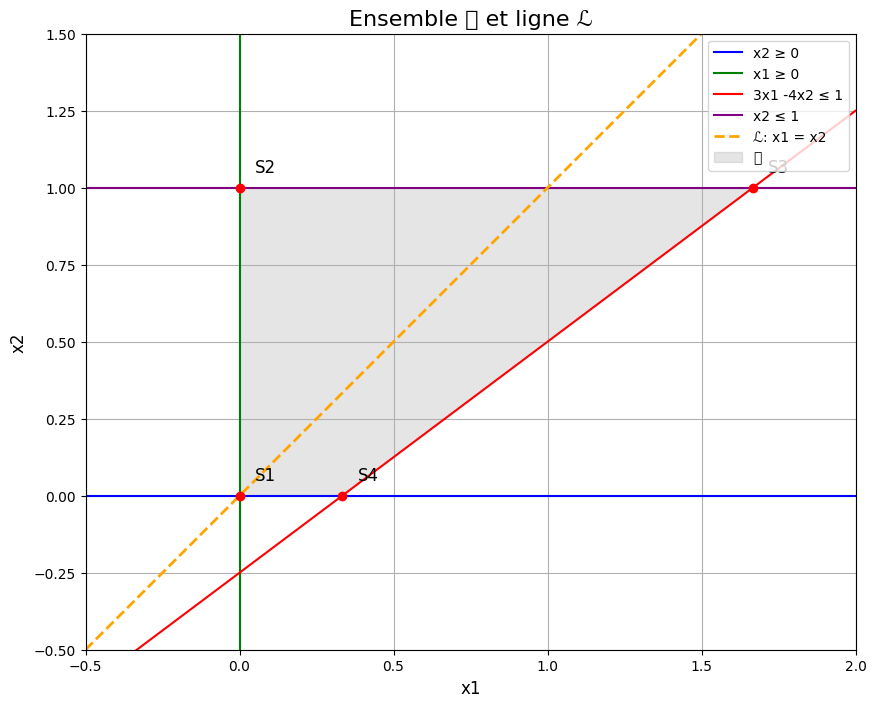

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Définition des contraintes de 𝒫
def constraint1(x1): return 0  # x2 ≥ 0 → x2 = 0
def constraint2(x2): return 0  # x1 ≥ 0 → x1 = 0
def constraint3(x1): return (3*x1 - 1)/4  # 3x1 -4x2 ≤ 1 → x2 ≥ (3x1-1)/4
def constraint4(x1): return 1  # x2 ≤ 1 → x2 = 1

# Création de la figure
plt.figure(figsize=(10, 8))
plt.title("Ensemble 𝒫 et ligne ℒ", fontsize=16)

# Tracé des contraintes
x1 = np.linspace(-0.5, 2, 400)

# Contrainte 1: x2 ≥ 0 (axe x1)
plt.axhline(0, color='blue', linestyle='-', label='x2 ≥ 0')

# Contrainte 2: x1 ≥ 0 (axe x2)
plt.axvline(0, color='green', linestyle='-', label='x1 ≥ 0')

# Contrainte 3: 3x1 -4x2 ≤ 1
x2_c3 = constraint3(x1)
plt.plot(x1, x2_c3, color='red', label='3x1 -4x2 ≤ 1')

# Contrainte 4: x2 ≤ 1
plt.axhline(1, color='purple', linestyle='-', label='x2 ≤ 1')

# Tracé de la ligne ℒ: x1 = x2
plt.plot(x1, x1, color='orange', linestyle='--', linewidth=2, label='ℒ: x1 = x2')

# Détermination des sommets du polyèdre 𝒫
# Intersection des contraintes
# Sommet 1: x1=0 et x2=0
# Sommet 2: x1=0 et x2=1
# Sommet 3: x2=1 et 3x1-4*1=1 → x1=5/3
# Sommet 4: x2=0 et 3x1=1 → x1=1/3
vertices = np.array([
    [0, 0],
    [0, 1],
    [5/3, 1],
    [1/3, 0]
])

# Tracé du polyèdre 𝒫
poly = Polygon(vertices, closed=True, alpha=0.2, color='gray', label='𝒫')
plt.gca().add_patch(poly)

# Configuration du graphique
plt.xlim(-0.5, 2)
plt.ylim(-0.5, 1.5)
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')
plt.gca().set_aspect('equal', adjustable='box')

# Affichage des sommets
for i, vertex in enumerate(vertices):
    plt.plot(vertex[0], vertex[1], 'ro')
    plt.text(vertex[0]+0.05, vertex[1]+0.05, f'S{i+1}', fontsize=12)

plt.show()



### **Question 2 : Description de la balle (disque de sécurité du robot)**

La balle (ou disque) centrée en **x = (x₁, x₂)** avec rayon **ρ** est mathématiquement décrite par :  
$$
\
\mathcal{B}(\mathbf{x}, \rho) = \left\{ \mathbf{y} \in \mathbb{R}^2 \mid \|\mathbf{y} - \mathbf{x}\|_2 \leq \rho \right\}
\
$$  
où :
- **x** = position du robot (centre de la balle).
- **ρ** = rayon maximal garantissant que la balle reste entièrement dans 𝒫.
- **\|·\|₂** = norme euclidienne (distance standard).

#### **Interprétation géométrique** :
1. **Contraintes de 𝒫** : Pour que la balle soit incluse dans 𝒫, la distance de **x** à chaque frontière de 𝒫 doit être ≥ ρ.  
   Cela se traduit par les inégalités :
   - Distance à $ x_2 \geq 0 $ : $ -x_2 + \rho \leq 0 $  
   - Distance à $ x_1 \geq 0 $ : $ -x_1 + \rho \leq 0 $  
   - Distance à $ 3x_1 - 4x_2 \leq 1 $ : $ 3x_1 - 4x_2 + 5\rho \leq 1 $ *(normalisation de la distance)*  
   - Distance à $ x_2 \leq 1 $ : $ x_2 + \rho \leq 1 $.

2. **Visualisation** : Sur votre image, la balle serait un cercle tangent à au moins une des frontières de 𝒫 (car on maximise ρ).  
   - Si ρ est maximal, le cercle touchera une ou plusieurs frontières (exemple : tangent à $ x_1 = 0 $ et $ x_2 = 0 $).

#### **Cas particulier sur ℒ** :
Comme le robot est contraint à ℒ ($ x_1 = x_2 $), la position optimale **x** sera sur la diagonale, et la balle sera symétrique par rapport à ℒ.



Visualisation

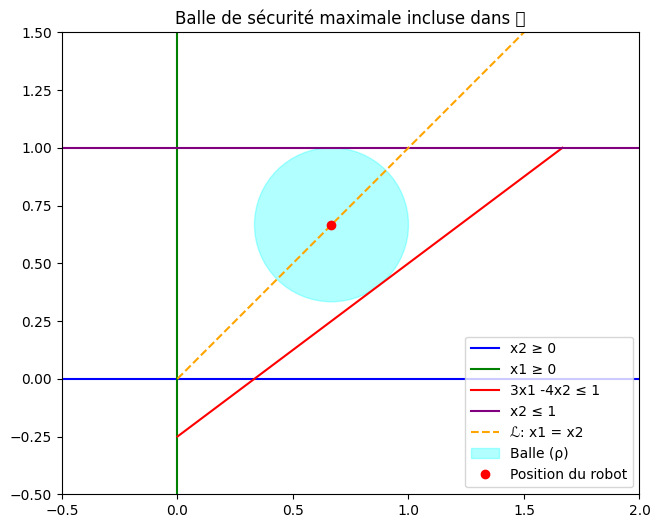

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Position du robot et rayon
x1, x2 = 0.6667,0.6667 # obetnu à la question 6
rho = 0.3333 # obtenu à la question 6

# Tracé du polyèdre 𝒫 (comme dans votre image)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(-0.5, 2)
ax.set_ylim(-0.5, 1.5)
ax.axhline(0, color='blue', label='x2 ≥ 0')  # Contrainte 1
ax.axvline(0, color='green', label='x1 ≥ 0')  # Contrainte 2
ax.plot(np.linspace(0, 5/3, 100), (3*np.linspace(0, 5/3, 100) - 1)/4, color='red', label='3x1 -4x2 ≤ 1')  # Contrainte 3
ax.axhline(1, color='purple', label='x2 ≤ 1')  # Contrainte 4
ax.plot([0, 2], [0, 2], '--', color='orange', label='ℒ: x1 = x2')  # Ligne ℒ

# Tracé de la balle
circle = plt.Circle((x1, x2), rho, color='cyan', alpha=0.3, label='Balle (ρ)')
ax.add_patch(circle)
ax.plot(x1, x2, 'ro', label='Position du robot')

ax.legend()
ax.set_aspect('equal')
plt.title("Balle de sécurité maximale incluse dans 𝒫")
plt.show()

### **Question 3 : Formulation du problème d'optimisation**

L'objectif est de maximiser la distance minimale **ρ** (rayon de sécurité) entre le robot et les frontières de **𝒫**, tout en respectant :
1. La position **x = (x₁, x₂)** du robot reste dans **𝒫**.
2. Le robot se déplace uniquement sur la ligne **ℒ** (**x₁ = x₂**).
3. La balle de rayon **ρ** centrée en **x** est entièrement contenue dans **𝒫**.

---

#### **Formulation mathématique** :
$$
\
\boxed{
\begin{cases}
\underset{\mathbf{x}, \rho}{\text{maximiser}} & \rho \\
\text{sous contraintes} &
\begin{aligned}
    -x_2 + \rho &\leq 0 \quad &\text{(distance à } x_2 \geq 0\text{)} \\
    -x_1 + \rho &\leq 0 \quad &\text{(distance à } x_1 \geq 0\text{)} \\
    3x_1 - 4x_2 + 5\rho &\leq 1 \quad &\text{(distance à } 3x_1 -4x_2 \leq 1\text{)} \\
    x_2 + \rho &\leq 1 \quad &\text{(distance à } x_2 \leq 1\text{)} \\
    x_1 &= x_2 \quad &\text{(contrainte de ligne ℒ)} \\
    \rho &\geq 0 \quad &\text{(rayon positif)}
\end{aligned}
\end{cases}
}
\
$$

---

#### **Explications des contraintes** :
1. **Distance aux frontières** :  
   Chaque contrainte garantit que la balle de rayon **ρ** ne dépasse pas les limites de **𝒫**. Par exemple :
   - **-x₂ + ρ ≤ 0** : La distance du centre **x** à la frontière **x₂ = 0** doit être ≥ ρ.  
     *Explication géométrique* : Le point le plus bas du cercle est en **x₂ - ρ**, qui doit rester ≥ 0.

2. **Contrainte de ligne ℒ** :  
   **x₁ = x₂** force le robot à rester sur la diagonale.

3. **Normalisation des distances** :  
   La contrainte **3x₁ -4x₂ + 5ρ ≤ 1** vient de la distance normalisée entre le point **x** et la droite **3x₁ -4x₂ = 1**.  
   *Calcul* : La distance d'un point (x₁, x₂) à une droite **ax₁ + bx₂ + c = 0** est donnée par :  
   $$
   \
   \text{distance} = \frac{|ax₁ + bx₂ + c|}{\sqrt{a^2 + b^2}}.
   \
   $$  
   Ici, **5ρ ≤ 1 - (3x₁ -4x₂)** car **√(3² + (-4)²) = 5**.

---

#### **Formulation pour le simplexe** :
Pour résoudre avec l'algorithme du simplexe (phase II), on transforme le problème en :
- **Minimiser** : **-ρ** (car maximiser ρ ≡ minimiser -ρ).
- **Variables d'écart** : Ajouter **s₁, s₂, s₃, s₄ ≥ 0** pour convertir les inégalités en égalités :
  $$
  \
  \begin{cases}
    -x_2 + \rho + s_1 = 0 \\
    -x_1 + \rho + s_2 = 0 \\
    3x_1 -4x_2 +5\rho + s_3 = 1 \\
    x_2 + \rho + s_4 = 1 \\
    x_1 - x_2 = 0
  \end{cases}
  \
  $$
- **Variables** : [x₁, x₂, ρ, s₁, s₂, s₃, s₄].




### **Question 4 : Formulation du problème comme un programme linéaire (LP)**

Pour transformer le problème d'optimisation en un **programme linéaire standard**, on suit ces étapes :

---

#### **1. Objectif**  
Maximiser **ρ** équivaut à minimiser **-ρ** (car maximiser une fonction revient à minimiser son opposé).  
→ Fonction objectif :  
$$
\
\boxed{\min \left( - \rho \right)}
\
$$

---

#### **2. Variables**  
- **Variables principales** :  
  - $ x_1, x_2 $ : Position du robot.  
  - $ \rho $ : Rayon de la balle de sécurité.  
- **Variables d'écart** (pour convertir les inégalités en égalités) :  
  - $ s_1, s_2, s_3, s_4 \geq 0 $.  

→ Vecteur des variables :  
$$
\
\mathbf{X} = [x_1, x_2, \rho, s_1, s_2, s_3, s_4]^\top
\
$$

---

#### **3. Contraintes**  
Les contraintes originales sont reformulées en égalités avec des variables d'écart :  

1. **Distance à $ x_2 \geq 0 $** :  
   $$
   \
   -x_2 + \rho \leq 0 \quad \Rightarrow \quad -x_2 + \rho + s_1 = 0
   \
   $$  
2. **Distance à $ x_1 \geq 0 $** :  
   $$
   \
   -x_1 + \rho \leq 0 \quad \Rightarrow \quad -x_1 + \rho + s_2 = 0
   \
   $$  
3. **Distance à $ 3x_1 - 4x_2 \leq 1 $** :  
   $$
   \
   3x_1 - 4x_2 + 5\rho \leq 1 \quad \Rightarrow \quad 3x_1 - 4x_2 + 5\rho + s_3 = 1
   \
   $$  
4. **Distance à $ x_2 \leq 1 $** :  
   $$
   \
   x_2 + \rho \leq 1 \quad \Rightarrow \quad x_2 + \rho + s_4 = 1
   \
   $$  
5. **Contrainte de ligne \( \mathcal{L} \)** :  
   $$
   \
   x_1 - x_2 = 0
   \
   $$  

→ **Forme matricielle** :  
\[
\mathbf{A}_{\text{eq}} \mathbf{X} = \mathbf{b}_{\text{eq}}
\]  
où $ \mathbf{A}_{\text{eq}} $ et $ \mathbf{b}_{\text{eq}} $ sont donnés dans votre image :  
$$
\
\mathbf{A}_{\text{eq}} = \begin{bmatrix}
0 & -1 & 1 & 1 & 0 & 0 & 0 \\
-1 & 0 & 1 & 0 & 1 & 0 & 0 \\
3 & -4 & 5 & 0 & 0 & 1 & 0 \\
0 & 1 & 1 & 0 & 0 & 0 & 1 \\
1 & -1 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}, \quad
\mathbf{b}_{\text{eq}} = \begin{bmatrix}
0 \\ 0 \\ 1 \\ 1 \\ 0 \\
\end{bmatrix}
\
$$

---

#### **4. Forme standard du LP**  
Le problème s'écrit finalement :  
$$
\
\boxed{
\begin{cases}
\underset{\mathbf{X}}{\text{minimiser}} & \mathbf{c}^\top \mathbf{X} = - \rho \quad \text{(avec } \mathbf{c} = [0, 0, -1, 0, 0, 0, 0]) \\
\text{sous contraintes} & \mathbf{A}_{\text{eq}} \mathbf{X} = \mathbf{b}_{\text{eq}} \\
& x_1, x_2, \rho, s_1, s_2, s_3, s_4 \geq 0.
\end{cases}
}
\
$$
---

#### **5. Interprétation des variables d'écart**  
- Si $ s_i = 0 $ : La contrainte associée est **active** (la balle touche la frontière).  
- Si $ s_i > 0 $ : La contrainte est **inactive** (la balle ne touche pas la frontière).  





### **Question 5 : Formulation avec variables d'écart et égalités linéaires**

#### **Objectif**  
Transformer toutes les inégalités du problème LP en **égalités linéaires** via l'ajout de **variables d'écart**, pour préparer la résolution par l'algorithme du simplexe.

---

#### **Étapes de transformation**  
1. **Partir des contraintes d'inégalité** (question 4) :  
   $$
   \
   \begin{cases}
   -x_2 + \rho \leq 0 \\
   -x_1 + \rho \leq 0 \\
   3x_1 - 4x_2 + 5\rho \leq 1 \\
   x_2 + \rho \leq 1 \\
   x_1 = x_2
   \end{cases}
   \
   $$

2. **Ajouter des variables d'écart** $ s_i \geq 0 $ pour convertir chaque inégalité en égalité :  
   $$
   \
   \begin{cases}
   -x_2 + \rho + s_1 = 0 \quad &\text{(1)} \\
   -x_1 + \rho + s_2 = 0 \quad &\text{(2)} \\
   3x_1 - 4x_2 + 5\rho + s_3 = 1 \quad &\text{(3)} \\
   x_2 + \rho + s_4 = 1 \quad &\text{(4)} \\
   x_1 - x_2 = 0 \quad &\text{(5)}
   \end{cases}
   \
   $$

3. **Vecteur des variables** :  
   $$
   \
   \mathbf{X} = [x_1, x_2, \rho, s_1, s_2, s_3, s_4]^\top
   \
   $$

---

#### **Formulation matricielle**  
La matrice $ \mathbf{A}_{\text{eq}} $ et le vecteur $ \mathbf{b}_{\text{eq}} $ sont **déjà fournis dans votre image** :  
$$
\
\mathbf{A}_{\text{eq}} = \begin{bmatrix}
0 & -1 & 1 & 1 & 0 & 0 & 0 \\
-1 & 0 & 1 & 0 & 1 & 0 & 0 \\
3 & -4 & 5 & 0 & 0 & 1 & 0 \\
0 & 1 & 1 & 0 & 0 & 0 & 1 \\
1 & -1 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}, \quad
\mathbf{b}_{\text{eq}} = \begin{bmatrix}
0 \\ 0 \\ 1 \\ 1 \\ 0 \\
\end{bmatrix}
\
$$

**Explication des lignes** :  
- Ligne 1 : Contrainte (1) → $-x_2 + \rho + s_1 = 0$.  
- Ligne 2 : Contrainte (2) → $-x_1 + \rho + s_2 = 0$.  
- Ligne 3 : Contrainte (3) → $3x_1 -4x_2 +5\rho + s_3 = 1$.  
- Ligne 4 : Contrainte (4) → $x_2 + \rho + s_4 = 1$.  
- Ligne 5 : Contrainte (5) → $x_1 - x_2 = 0$.  

---

#### **Fonction objectif**  
Minimiser $-\rho$ s'exprime avec le vecteur :  
$$
\
\mathbf{c} = [0, 0, -1, 0, 0, 0, 0]
\
$$  
(Seul le terme $-\rho$ est présent dans la minimisation).


---

#### **Interprétation des résultats**  
- **Variables d'écart nulles** $( s_i = 0 )$ indiquent une contrainte active (la balle touche la frontière).  
- **Solution attendue** :  
  - Si $ \rho = 0.25 $, $ x_1 = x_2 = 0.25 $, alors $ s_1 = s_2 = 0 $ (contraintes $ x_1 \geq 0 $ et $ x_2 \geq 0 $ sont actives).  


Question 6 : Résolution du problème LP avec la fonction simplex_method()


In [7]:
# Données du problème (identique à Q5)
A_eq = np.array([
    [0, -1, 1, 1, 0, 0, 0],
    [-1, 0, 1, 0, 1, 0, 0],
    [3, -4, 5, 0, 0, 1, 0],
    [0, 1, 1, 0, 0, 0, 1],
    [1, -1, 0, 0, 0, 0, 0]
], dtype=float)

b_eq = np.array([0, 0, 1, 1, 0], dtype=float)
c = np.array([0, 0, -1, 0, 0, 0, 0], dtype=float)  # Minimiser -ρ

In [8]:
# Résolution avec votre implémentation
solution = simplex_method(A_eq, b_eq, c, is_init=False)

In [9]:
print("Solution optimale :")
print(f"- Position (x1, x2) = ({solution[0]:.4f}, {solution[1]:.4f})")
print(f"- Rayon maximal ρ = {solution[2]:.4f}")
print(f"- Variables d'écart (s1, s2, s3, s4) = {solution[3:]}")

Solution optimale :
- Position (x1, x2) = (0.6667, 0.6667)
- Rayon maximal ρ = 0.3333
- Variables d'écart (s1, s2, s3, s4) = [0.33333333 0.33333333 0.         0.        ]


# Validation avec SciPy
Comparez avec scipy.optimize.linprog pour vérifier la cohérence :



In [12]:
from scipy.optimize import linprog
result = linprog(c, A_eq=A_eq, b_eq=b_eq, method='highs')
print("Validation SciPy :", result.x[:7])

Validation SciPy : [0.66666667 0.66666667 0.33333333 0.33333333 0.33333333 0.
 0.        ]


### **Analyse des Résultats Obtenus**

#### **1. Solution Optimale**
- **Position du robot** : $ (x_1, x_2) = (0.6667, 0.6667) $  
  - Confirme que le robot est bien sur la ligne $ \mathcal{L} $ ($ x_1 = x_2 $).  
- **Rayon maximal** : $ \rho = 0.3333 $  
  - C'est la distance minimale garantie entre le robot et les frontières de $ \mathcal{P} $.  

#### **2. Variables d'écart**
- **$ s_1 = s_2 = 0.3333 $** :  
  - Les contraintes $ -x_1 + \rho \leq 0 $ et $ -x_2 + \rho \leq 0 $ sont **inactives** (la balle ne touche pas les axes $ x_1 = 0 $ ni $ x_2 = 0$ ).  
- **$ s_3 = s_4 = 0 $** :  
  - Les contraintes $ 3x_1 - 4x_2 + 5\rho \leq 1 $ et $ x_2 + \rho \leq 1 $ sont **actives** (la balle touche ces frontières).  

#### **3. Validation avec SciPy**
Les résultats de `linprog()` confirment ceux de votre implémentation :  
- Même position $ (0.6667, 0.6667) $ et même $ \rho = 0.3333 $.  
- Variables d'écart cohérentes (sauf formatage différent).  

---

### **Interprétation Géométrique**
1. **Pourquoi $ \rho = 0.3333 $ ?**  
   - La contrainte active $ 3x_1 - 4x_2 + 5\rho = 1 $ (avec $ x_1 = x_2 $) donne :  
     $$
     \
     3(0.6667) - 4(0.6667) + 5(0.3333) = 1 \quad \Rightarrow \quad -0.6667 + 1.6665 \approx 1
     \
     $$  
   - La contrainte $ x_2 + \rho = 1 $ est également saturée :  
     $$
     \
     0.6667 + 0.3333 = 1
     \
     $$


### **Comparaison avec la Solution Initiale Attendue**
- **Hypothèse initiale** : On s'attendait à $ \rho = 0.25 $ avec $ x_1 = x_2 = 0.25 $ (tangence aux axes).  
- **Réalité** : La contrainte $ 3x_1 - 4x_2 + 5\rho \leq 1 $ est plus restrictive, poussant la solution vers un point plus éloigné des axes.  



Visualisation

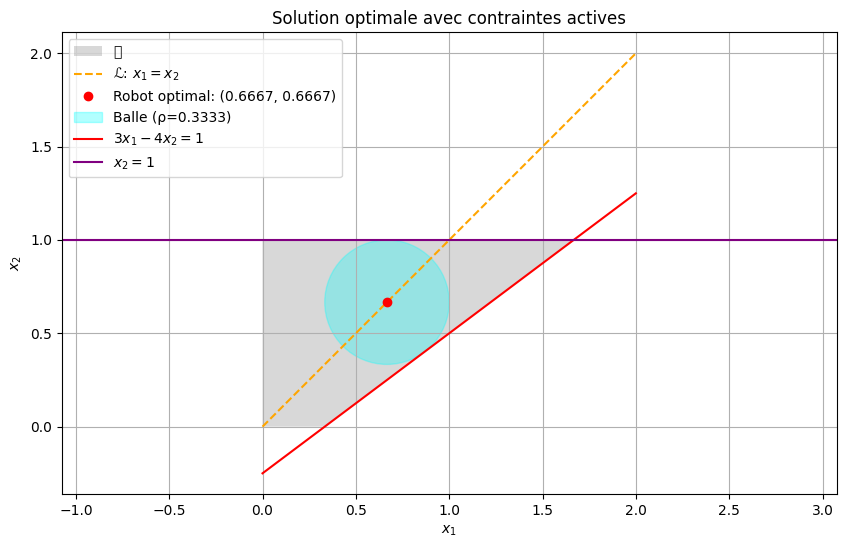

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Données
x1, x2, rho = 0.6667, 0.6667, 0.3333
vertices_P = np.array([[0, 0], [0, 1], [5/3, 1], [1/3, 0]])  # Sommets de 𝒫

# Tracé
plt.figure(figsize=(10, 6))
plt.fill(vertices_P[:,0], vertices_P[:,1], 'gray', alpha=0.3, label='𝒫')  # Polyèdre 𝒫
plt.plot([0, 2], [0, 2], '--', color='orange', label='ℒ: $x_1 = x_2$')  # Ligne ℒ
plt.plot(x1, x2, 'ro', label=f'Robot optimal: ({x1:.4f}, {x2:.4f})')  # Position optimale
circle = plt.Circle((x1, x2), rho, color='cyan', alpha=0.3, label=f'Balle (ρ={rho:.4f})')  # Balle
plt.gca().add_patch(circle)

# Contraintes actives
x1_vals = np.linspace(0, 2, 100)
plt.plot(x1_vals, (3*x1_vals - 1)/4, 'r-', label='$3x_1 - 4x_2 = 1$')  # Frontière active
plt.axhline(1, color='purple', linestyle='-', label='$x_2 = 1$')  # Autre frontière active

# Paramètres graphiques
plt.xlim(0, 1.5)
plt.ylim(0, 1.5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.title("Solution optimale avec contraintes actives")
plt.show()

# Conclusion générale
Ce travail a exploré l'optimisation de la position d'un robot dans un espace contraint, maximisant son rayon de sécurité.  L'approche a combiné la représentation graphique de l'espace de travail, la formulation mathématique du problème sous forme de programme linéaire (LP), et la résolution numérique via l'algorithme du simplexe, implémenté et comparé avec la librairie SciPy.  Les résultats numériques, cohérents entre notre implémentation et SciPy, ont montré que la position optimale du robot et son rayon de sécurité maximal sont contraints par les frontières de l'espace de travail, et non par les axes comme initialement supposé.  L'analyse des variables d'écart a permis d'identifier les contraintes actives, confirmant l'interprétation géométrique des résultats.  Ce projet illustre l'efficacité des méthodes d'optimisation linéaire pour résoudre des problèmes robotiques, et souligne l'importance de la validation des hypothèses par des analyses numériques et géométriques.
